In [6]:
%pip install numpy opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


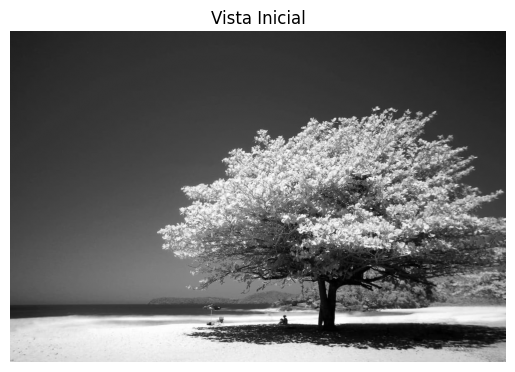

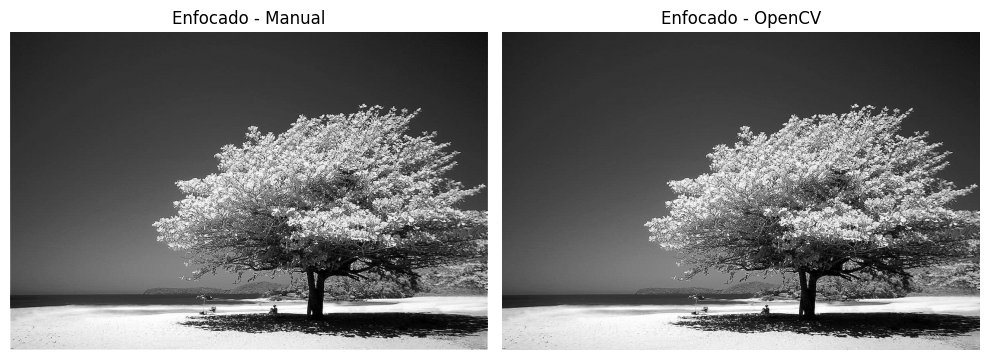

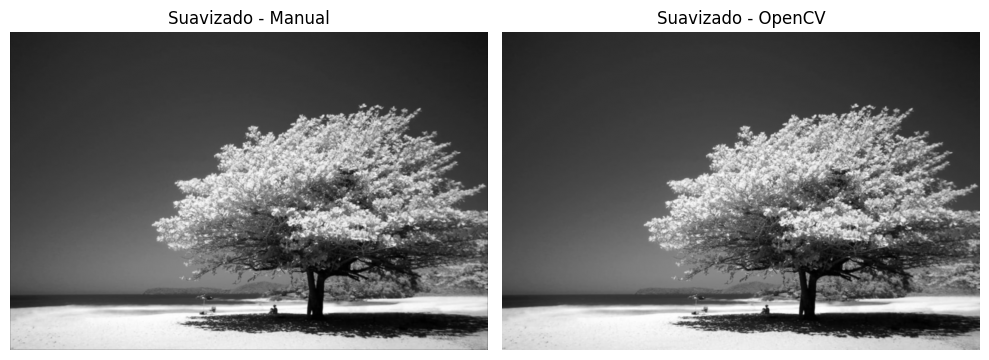

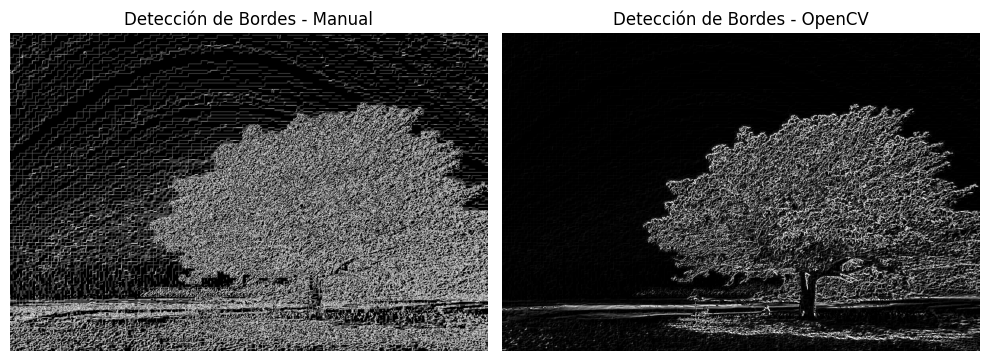

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1284: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvNamedWindow'


In [10]:
# 🛠️ Librerías necesarias para procesamiento de imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 🖼️ Cargar la imagen en formato de grises
imagen_original = cv2.imread('imagen1.jpg', cv2.IMREAD_GRAYSCALE)

# 📊 Visualización de la imagen original
plt.imshow(imagen_original, cmap='gray')
plt.title('Vista Inicial')
plt.axis('off')
plt.show()

# ⚙️ Función personalizada para realizar convolución 2D
def convolucion_manual(imagen, filtro):
    alto, ancho = imagen.shape
    f_alto, f_ancho = filtro.shape
    margen_y, margen_x = f_alto // 2, f_ancho // 2

    # 🧱 Ampliar los bordes con ceros
    imagen_expandida = np.pad(imagen, ((margen_y, margen_y), (margen_x, margen_x)), mode='constant', constant_values=0)
    imagen_resultado = np.zeros_like(imagen)

    # 🔄 Recorrer cada píxel y aplicar el filtro
    for y in range(alto):
        for x in range(ancho):
            zona = imagen_expandida[y:y+f_alto, x:x+f_ancho]
            valor = np.sum(zona * filtro)
            imagen_resultado[y, x] = np.clip(valor, 0, 255)

    return imagen_resultado.astype(np.uint8)

# 🔎 Definir filtros (kernels) para diferentes efectos
filtro_enfocar = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

filtro_suavizar = np.ones((3, 3), np.float32) / 9

filtro_sobel_h = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

filtro_sobel_v = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])

# 🧪 Aplicar filtros de forma manual
img_enfocada = convolucion_manual(imagen_original, filtro_enfocar)
img_suave = convolucion_manual(imagen_original, filtro_suavizar)
img_sobel_h = convolucion_manual(imagen_original, filtro_sobel_h)
img_sobel_v = convolucion_manual(imagen_original, filtro_sobel_v)

# 📐 Calcular magnitud de bordes
img_bordes = np.sqrt(img_sobel_h**2 + img_sobel_v**2)
img_bordes = np.clip(img_bordes, 0, 255).astype(np.uint8)

# 🖥️ Comparar resultados con OpenCV
resultado_cv_enfocar = cv2.filter2D(imagen_original, -1, filtro_enfocar)
resultado_cv_suavizar = cv2.filter2D(imagen_original, -1, filtro_suavizar)
resultado_cv_bordes = cv2.filter2D(imagen_original, -1, filtro_sobel_h) + cv2.filter2D(imagen_original, -1, filtro_sobel_v)

# 🖼️ Mostrar imágenes comparativas
def comparar_visual(titulo, imagen_1, imagen_2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(imagen_1, cmap='gray')
    axes[0].set_title(f'{titulo} - Manual')
    axes[1].imshow(imagen_2, cmap='gray')
    axes[1].set_title(f'{titulo} - OpenCV')
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

# 🎯 Mostrar comparaciones de resultados
comparar_visual('Enfocado', img_enfocada, resultado_cv_enfocar)
comparar_visual('Suavizado', img_suave, resultado_cv_suavizar)
comparar_visual('Detección de Bordes', img_bordes, resultado_cv_bordes)

# 🔧 Función sin efecto, necesaria para el slider
def sin_accion(valor):
    pass

# 🪟 Crear interfaz con barra deslizante para interacción
cv2.namedWindow("Visualizador Interactivo", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Visualizador Interactivo", 700, 400)
cv2.createTrackbar("Centro (K)", "Visualizador Interactivo", 1, 10, sin_accion)

while True:
    centro_valor = cv2.getTrackbarPos("Centro (K)", "Visualizador Interactivo")

    # 🔩 Filtro modificable por el usuario
    kernel_dinamico = np.array([[0, -1, 0],
                                [-1, 4 + centro_valor, -1],
                                [0, -1, 0]])

    imagen_filtrada = cv2.filter2D(imagen_original, -1, kernel_dinamico)

    original_bgr = cv2.cvtColor(imagen_original, cv2.COLOR_GRAY2BGR)
    filtrada_bgr = cv2.cvtColor(imagen_filtrada, cv2.COLOR_GRAY2BGR)

    # ✍️ Añadir etiquetas a cada imagen
    texto_pos = (10, 20)
    cv2.putText(original_bgr, 'Original', texto_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)
    cv2.putText(filtrada_bgr, 'Procesada', texto_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1, cv2.LINE_AA)

    # 🔄 Concatenar imágenes horizontalmente
    vista_final = np.hstack((original_bgr, filtrada_bgr))

    cv2.imshow("Visualizador Interactivo", vista_final)

    if cv2.waitKey(1) & 0xFF == 27:  # Tecla ESC
        break

cv2.destroyAllWindows()
